In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2
import sample_data

np.random.seed(0)
N_train = 50000; N_test = 0
N = N_train + N_test
train = np.arange(N_train); test = np.arange(N_test) + N_train
n_min = 100; n_max = 100

#X, y = sample_data.synthetic_control(N, n_min, n_max, even=False, sigma=0.0)
X, y = sample_data.periodic(N, n_min, n_max, t_max=2*np.pi, even=False,
                            A=1., sigma=1e-0, w_min=0.1, w_max=1.)

Using TensorFlow backend.


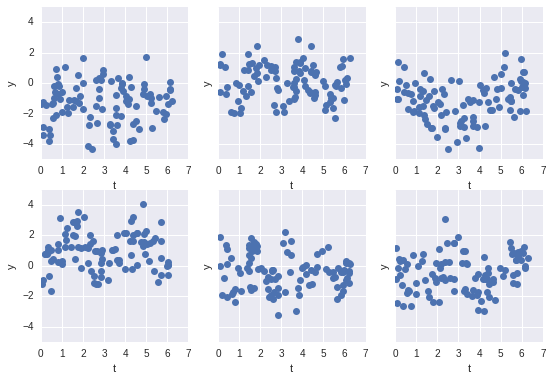

In [2]:
fig, ax = plt.subplots(2, 3, sharey=True)
for j in range(6):
#    i = np.where(y == j)[0][0]
    i = j
#    ax.ravel()[j].plot(np.linspace(0, n_max, n_max), X[i], 'o')
    ax.ravel()[j].plot(X[i][:, 0], X[i][:, 1], 'o')
    ax.ravel()[j].set(xlabel="t", ylabel="y")

In [ ]:
import os
import tensorflow as tf
from keras import backend as K
from keras.layers import (Input, Dense, TimeDistributed, Activation, LSTM, Dropout, 
                          merge, Reshape, Flatten, RepeatVector)
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ProgbarLogger, TensorBoard
from IPython.display import clear_output


def uneven_lstm_autoencoder(lstm_size, lr, drop_frac):
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.20)))
    K.set_session(sess)
    run = "lstm2_{}_{:1.0e}_drop{}".format(lstm_size, lr, drop_frac).replace('e-', 'm').replace('.', '')

    main_input = Input(shape=(n_max, 2))
    lstm_in_1 = LSTM(lstm_size, input_dim=2, return_sequences=True)(main_input)
    dropout_in = Dropout(drop_frac)(lstm_in_1)
    lstm_in_2 = LSTM(lstm_size, return_sequences=False)(dropout_in)
    aux_input = Input(shape=(n_max, 1), name='aux_input')
    tiled = RepeatVector(n_max)(lstm_in_2)
    merged = merge([aux_input, tiled], mode='concat')
    lstm_out_1 = LSTM(lstm_size, return_sequences=True)(merged)
    dropout_out = Dropout(drop_frac)(lstm_out_1)
    lstm_out_2 = LSTM(lstm_size, return_sequences=True)(dropout_out)
    output = TimeDistributed(Dense(1, activation='linear'))(lstm_out_2)
    model = Model(input=[main_input, aux_input], output=output)
    adam = Adam(lr=lr)
    model.compile(optimizer=adam, loss='mse', metrics=[])

    log_dir = os.path.expanduser('~/Dropbox/Documents/timeflow/keras_logs/auto/{}'.format(run))
    !rm -rf $log_dir
    #if os.path.exists(log_dir):
    #    raise Exception("Log directory already exists, not overwriting")
    history = model.fit([X[train], X[train][:, :, 0:1]], X[train][:, :, 1:2],# verbose=0,
                         nb_epoch=nb_epoch, batch_size=batch_size, validation_split=0.2,
                         callbacks=[ProgbarLogger(),
                                    TensorBoard(log_dir=log_dir, write_graph=False)])
    model.save_weights(os.path.join(log_dir, 'weights.h5'), overwrite=True)
    return (run, history, model)

In [ ]:
from itertools import product
from joblib import Parallel, delayed

batch_size = 250
nb_epoch = 25
            
Parallel(n_jobs=4)(delayed(uneven_lstm_autoencoder)(lstm_size, lr, drop_frac)
                   for lstm_size, lr, drop_frac in product([64, 128], [5e-4, 1e-3], [0.0, 0.25]))

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/25
Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/25
Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/25
Epoch 1/25
 5750/40000 [===>..........................] - ETA: 192s - loss: 1.7633